# US Marathon Race Factors and Adjusting Your Pacing Accordingly

### Overview

This is a data science project I created to model marathon times using weather data and elevation data as input features. I scraped data for over 400 marathon instances representing the aggregation of 20 races from years 2000 to 2022. Regularized linear regression and tree ensemble regression are used to model the average run times, female win times, and male win times. Ridge model coefficients for average run times are extracted to help the typical runner adjust their pacing plan to account for their race day conditions and run a smart race.

If you are interested in my code for __scraping data and compiling__ my original data set, please take a look at the __MarathonDataCollection.ipynb__ jupyter notebook.

The __data visualization and modeling__ is contained in the __MarathonPredictor.ipynb__ jupyter notebook. You will also need my most recent data table csv from the __full_df_csvs__ folder. The units in this data set are listed in the appendix at the bottom of this page.

---

### Introduction

As a runner who has struggled through a few marathons, I am familiar with the added strain that adverse weather and hills can introduce to an already taxing pursuit. A tactical runner would account for these race conditions when formulating their pacing plan before the race even begins, but such calculations require quantifying the likely impact of these factors. So in the interest of fellow marathon runners, I set out to investigate the following questions.

__Objective 1:__ Are variations in average marathon times connected to weather conditions and course elevation changes?

__Objective 2:__ Are marathon win times similarly connected to weather conditions and elevation changes?

__Objective 3:__ How can runners adjust their pacing plan to account for race day conditions and run a smart marathon?

I first compiled a data set by scraping marathon race results and course elevation profile metrics from the web and joined corresponding weather data queried from a NOAA database. This involved regex, beautiful soup, selenium, and a lot of data cleaning. (See MarathonDataCollection.ipynb if interested in the details.)

### Import packages

In [1]:
import pandas as pd
import numpy as np
import math
import time
import os
import re

from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
from matplotlib.ticker import FuncFormatter
from matplotlib.offsetbox import AnchoredText
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

pd.options.mode.chained_assignment = None  # default='warn'

%matplotlib widget

### Load full data

In [2]:
# Load full data
directory = 'full_df_csvs'
newest_full_df = [file for file in sorted(os.listdir(directory)) if file.endswith('.csv')][-1]
full_df = pd.read_csv(os.path.join(directory, newest_full_df))

# Update data types
full_df['Date'] = pd.to_datetime(full_df['Date'])
time_cols = ['Male Win','Female Win','Average Time','Time STD']
full_df[time_cols] = (full_df[time_cols].apply(pd.to_timedelta))

# full_df.dtypes

In [3]:
# Feature Variables
X = full_df[['Event Name', 'City', 'State', 
            'Date', 
            'Finishers', 'Males', 'Females', 'Percent Female',
            'Elev Gain', 'Elev Loss', 'Elev Max', 'Elev Min', 
            'STATION', 'LATITUDE', 'LONGITUDE', 'ELEVATION', 
            'TEMP', 'MAX', 'MIN', 'PRCP', 'DEWP', 'WDSP', 'RELHUM']]
# Dates will be in days (float) since Jan 1, 2000
X['Date'] = (pd.to_datetime(X['Date']) - pd.to_datetime('2000-01-01'))/np.timedelta64(1, 'D')

# Target Variables: Run times will be in seconds (float)
y_average = full_df['Average Time'] / np.timedelta64(1, 's')
y_male = full_df['Male Win'] / np.timedelta64(1, 's')
y_female = full_df['Female Win'] / np.timedelta64(1, 's')

### Exploratory Data Analysis

The main notebook MarathonPredictor.ipynb contains the code for modeling, data analysis, and figures. Some selected data visualizations are shown here. Not all input variables are expected to affect individual times, but they are still included to help account for the variances in average times and win times. Violin plots of marathon times by event show clear trends, which are likely tied to weather/climate, race course elevation profile, and the unique sampling of runners each event typically attracts. 

In [4]:
# Create a formatter for reading plot axes as h:mm or h:mm:ss
from matplotlib.ticker import FuncFormatter

def format_func(x, pos):
    hours = int(x//3600)
    minutes = int((x%3600)//60)
    seconds = int(x%60)

    return "{:d}:{:02d}".format(hours, minutes)
    # return "{:d}:{:02d}:{:02d}".format(hours, minutes, seconds)

formatter = FuncFormatter(format_func)

In [5]:
# see available built-in styles.
# plt.style.available

In [6]:
plt.style.use('seaborn-colorblind')

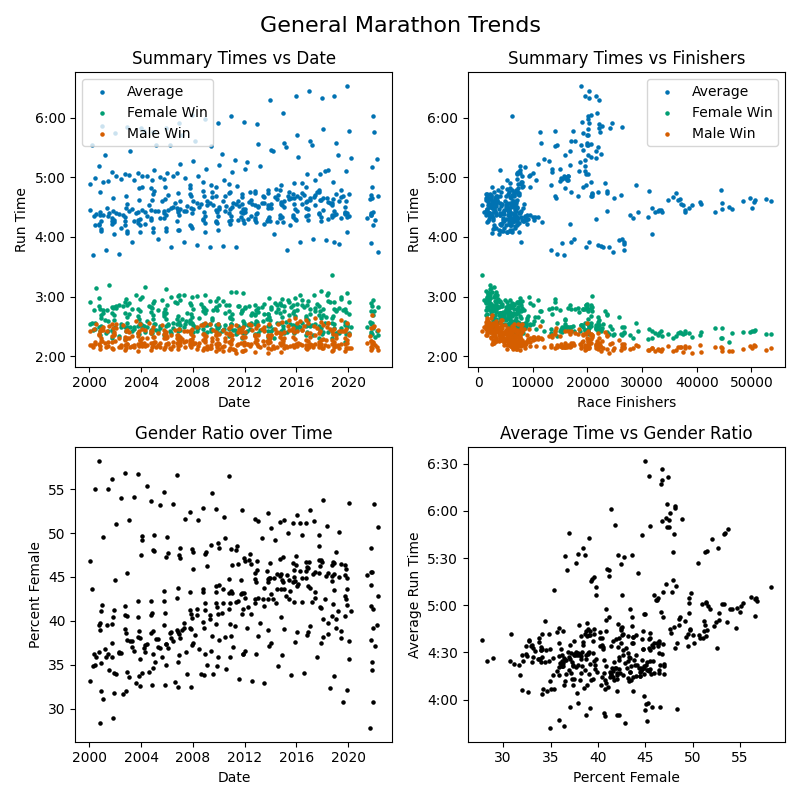

In [7]:
fig, axs = plt.subplots(2,2,figsize=(8,8))
((ax1,ax2),(ax3,ax4)) = axs

ax1.scatter(full_df['Date'],y_average, s=5, label='Average')
ax1.scatter(full_df['Date'],y_female, s=5, label='Female Win')
ax1.scatter(full_df['Date'],y_male, s=5, label='Male Win')
ax1.set_xlabel('Date')
ax1.set_ylabel('Run Time')
ax1.set_title('Summary Times vs Date')

ax2.scatter(full_df['Finishers'],y_average, s=5, label='Average')
ax2.scatter(full_df['Finishers'],y_female, s=5, label='Female Win')
ax2.scatter(full_df['Finishers'],y_male, s=5, label='Male Win')
ax2.set_xlabel('Race Finishers')
ax2.set_ylabel('Run Time')
ax2.set_title('Summary Times vs Finishers')

ax3.scatter(full_df['Date'],full_df['Percent Female'], color='k', s=5, label='_none')
ax3.set_xlabel('Date')
ax3.set_ylabel('Percent Female')
ax3.set_title('Gender Ratio over Time')

ax4.scatter(full_df['Percent Female'],y_average, color='k', s=5, label='Average')
ax4.set_xlabel('Percent Female')
ax4.set_ylabel('Average Run Time')
ax4.set_title('Average Time vs Gender Ratio')

# Set tick labels and legends
for ax in [ax1,ax2]:
    ax.yaxis.set_major_locator(mticker.MultipleLocator(base=3600))
    ax.yaxis.set_major_formatter(formatter)
    ax.legend()
ax4.yaxis.set_major_locator(mticker.MultipleLocator(base=1800))
ax4.yaxis.set_major_formatter(formatter)

fig.suptitle('General Marathon Trends', fontsize=16)
# ax2.xaxis.set_tick_params(rotation=45)
fig.tight_layout()

In [8]:
# Create a comparison of each Marathon based on mean of the Average Times from 2000-2022
event_rank = (full_df.groupby(by=['Event Name'])
                     .agg({'Average Time':np.mean})
                     .sort_values('Average Time')
                     .rename(columns={'Average Time':'Mean of Averages'})
                     .reset_index()
                    )
event_rank = event_rank.merge(full_df[['Event Name','Average Time']], how='inner', on='Event Name')
# print(event_rank.head())

# Convert times to floats for plotting
event_rank[['Average Time','Mean of Averages']] = event_rank[['Average Time','Mean of Averages']] / np.timedelta64(1, 's')
# print(event_rank.head())

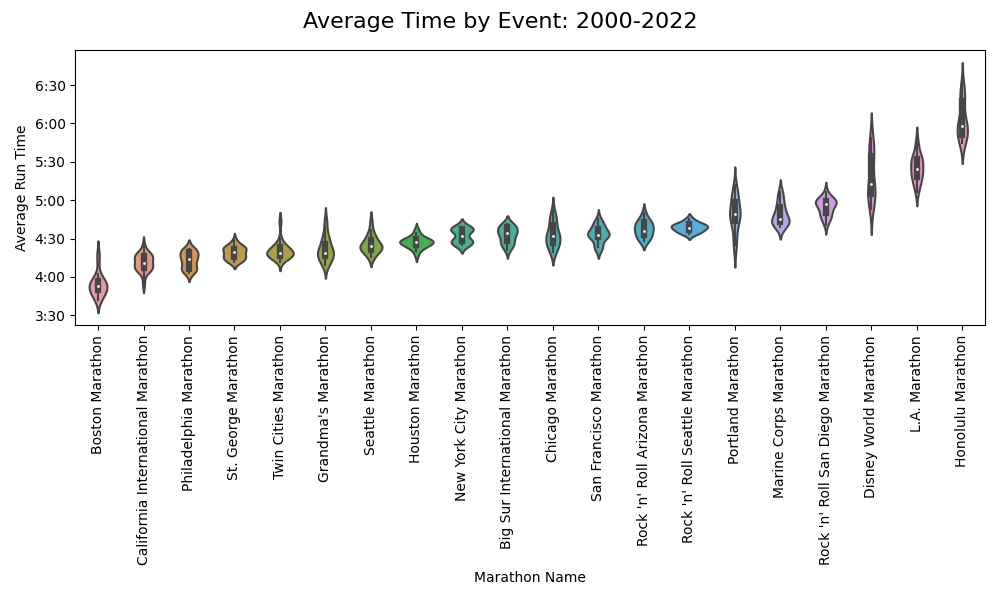

In [9]:
# Comparison of Average Run Time by Event Name
fig, ax1 = plt.subplots(1,1,figsize=(10,6))
sns.violinplot(x='Mean of Averages', y='Average Time', data=event_rank, ax=ax1);

labels = event_rank['Event Name'].unique()
ax1.xaxis.set_ticks(range(len(labels)),labels,rotation=90)
# ax1.xaxis.set_tick_params(rotation=90)
ax1.yaxis.set_major_locator(mticker.MultipleLocator(base=1800))
ax1.yaxis.set_major_formatter(formatter)
ax1.set_ylabel('Average Run Time')
ax1.set_xlabel('Marathon Name')
fig.suptitle('Average Time by Event: 2000-2022', fontsize=16)
fig.tight_layout()

In [10]:
# Create a comparison of each Marathon based on mean of the Female Win times from 2000-2022
event_rank_female = (full_df.groupby(by=['Event Name'])
                     .agg({'Female Win':np.mean})
                     .sort_values('Female Win')
                     .rename(columns={'Female Win':'Mean of Female Wins'})
                     .reset_index()
                    )
event_rank_female = event_rank_female.merge(full_df[['Event Name','Female Win']], how='inner', on='Event Name')
# print(event_rank_female.head())

# Convert times to floats for plotting
event_rank_female[['Female Win','Mean of Female Wins']] = event_rank_female[['Female Win','Mean of Female Wins']] / np.timedelta64(1, 's')
# print(event_rank_female.head())

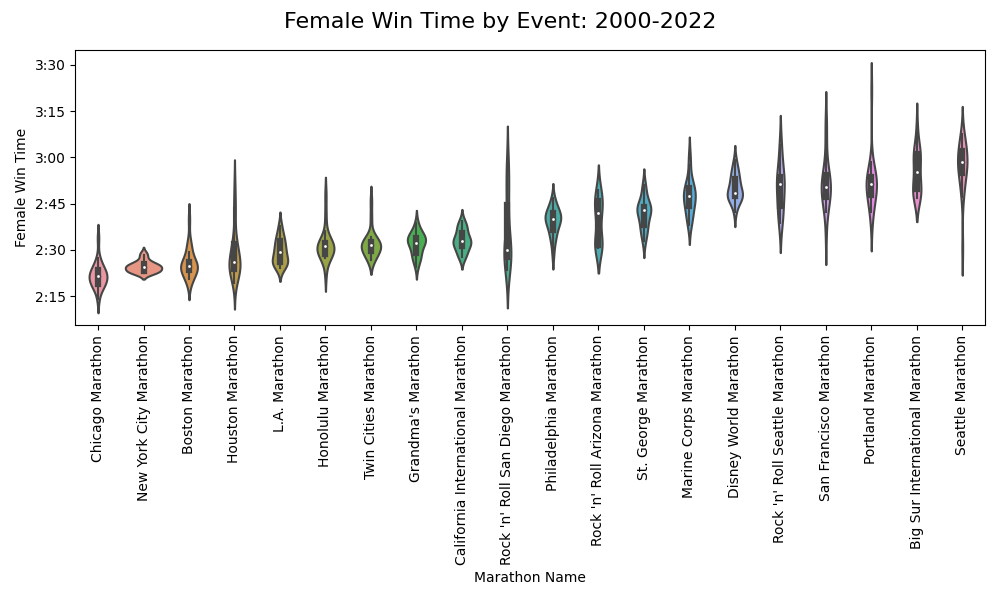

In [11]:
# Comparison of Female Wins by Event Name
fig, ax1 = plt.subplots(1,1,figsize=(10,6))
sns.violinplot(x='Mean of Female Wins', y='Female Win', data=event_rank_female, ax=ax1);

labels = event_rank_female['Event Name'].unique()
ax1.xaxis.set_ticks(range(len(labels)),labels,rotation=90)
# ax1.xaxis.set_tick_params(rotation=90)
ax1.yaxis.set_major_locator(mticker.MultipleLocator(base=900))
ax1.yaxis.set_major_formatter(formatter)
ax1.set_ylabel('Female Win Time')
ax1.set_xlabel('Marathon Name')
fig.suptitle('Female Win Time by Event: 2000-2022', fontsize=16)
fig.tight_layout()

In [12]:
# Create a comparison of each Marathon based on mean of the Male Win times from 2000-2022
event_rank_male = (full_df.groupby(by=['Event Name'])
                     .agg({'Male Win':np.mean})
                     .sort_values('Male Win')
                     .rename(columns={'Male Win':'Mean of Male Wins'})
                     .reset_index()
                    )
event_rank_male = event_rank_male.merge(full_df[['Event Name','Male Win']], how='inner', on='Event Name')
# print(event_rank_male.head())

# Convert times to floats for plotting
event_rank_male[['Male Win','Mean of Male Wins']] = event_rank_male[['Male Win','Mean of Male Wins']] / np.timedelta64(1, 's')
# print(event_rank_male.head())

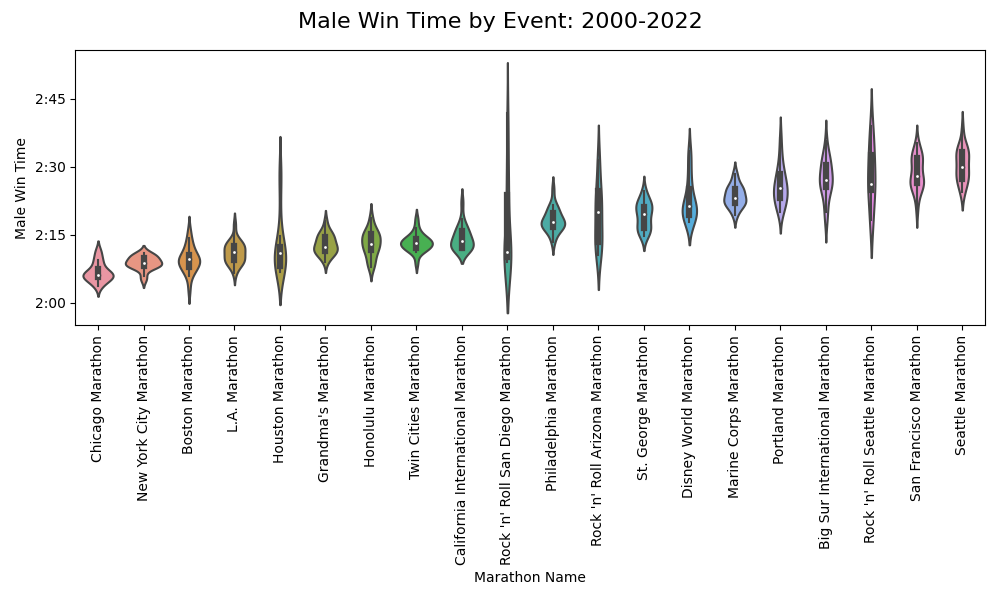

In [13]:
# Comparison of Male Wins by Event Name
fig, ax1 = plt.subplots(1,1,figsize=(10,6))
sns.violinplot(x='Mean of Male Wins', y='Male Win', data=event_rank_male, ax=ax1);

labels = event_rank_male['Event Name'].unique()
ax1.xaxis.set_ticks(range(len(labels)),labels,rotation=90)
# ax1.xaxis.set_tick_params(rotation=90)
ax1.yaxis.set_major_locator(mticker.MultipleLocator(base=900))
ax1.yaxis.set_major_formatter(formatter)
ax1.set_ylabel('Male Win Time')
ax1.set_xlabel('Marathon Name')
fig.suptitle('Male Win Time by Event: 2000-2022', fontsize=16)
fig.tight_layout()

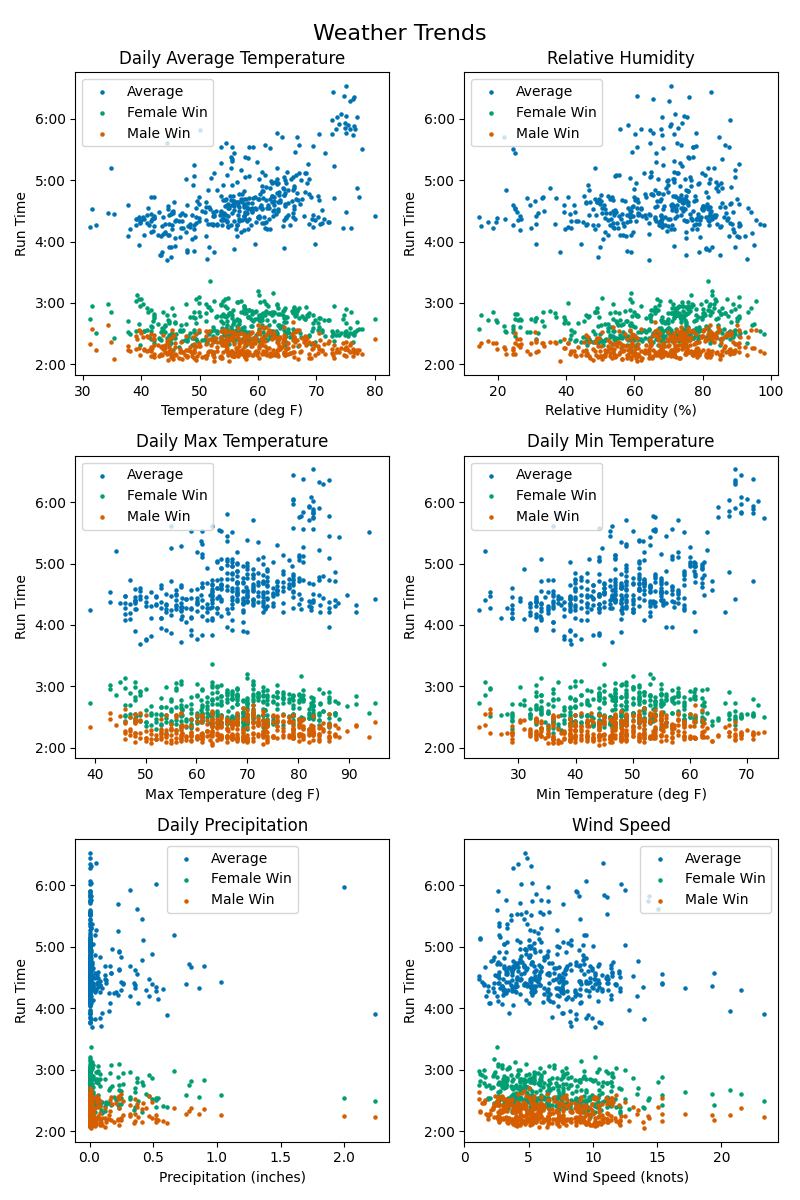

In [14]:
# Plot weather data
# 'TEMP', 'RELHUM',
# 'MAX', 'MIN',
# 'PRCP', 'WDSP'
fig, axs = plt.subplots(3,2,figsize=(8,12))
((ax1,ax2),(ax3,ax4),(ax5,ax6)) = axs

ax1.scatter(full_df['TEMP'],y_average, s=5, label='Average')
ax1.scatter(full_df['TEMP'],y_female, s=5, label='Female Win')
ax1.scatter(full_df['TEMP'],y_male, s=5, label='Male Win')
ax1.set_xlabel('Temperature (deg F)')
ax1.set_ylabel('Run Time')
ax1.set_title('Daily Average Temperature')

ax2.scatter(full_df['RELHUM'],y_average, s=5, label='Average')
ax2.scatter(full_df['RELHUM'],y_female, s=5, label='Female Win')
ax2.scatter(full_df['RELHUM'],y_male, s=5, label='Male Win')
ax2.set_xlabel('Relative Humidity (%)')
ax2.set_ylabel('Run Time')
ax2.set_title('Relative Humidity')

ax3.scatter(full_df['MAX'],y_average, s=5, label='Average')
ax3.scatter(full_df['MAX'],y_female, s=5, label='Female Win')
ax3.scatter(full_df['MAX'],y_male, s=5, label='Male Win')
ax3.set_xlabel('Max Temperature (deg F)')
ax3.set_ylabel('Run Time')
ax3.set_title('Daily Max Temperature')

ax4.scatter(full_df['MIN'],y_average, s=5, label='Average')
ax4.scatter(full_df['MIN'],y_female, s=5, label='Female Win')
ax4.scatter(full_df['MIN'],y_male, s=5, label='Male Win')
ax4.set_xlabel('Min Temperature (deg F)')
ax4.set_ylabel('Run Time')
ax4.set_title('Daily Min Temperature')

ax5.scatter(full_df['PRCP'],y_average, s=5, label='Average')
ax5.scatter(full_df['PRCP'],y_female, s=5, label='Female Win')
ax5.scatter(full_df['PRCP'],y_male, s=5, label='Male Win')
ax5.set_xlabel('Precipitation (inches)')
ax5.set_ylabel('Run Time')
ax5.set_title('Daily Precipitation')

ax6.scatter(full_df['WDSP'],y_average, s=5, label='Average')
ax6.scatter(full_df['WDSP'],y_female, s=5, label='Female Win')
ax6.scatter(full_df['WDSP'],y_male, s=5, label='Male Win')
ax6.set_xlabel('Wind Speed (knots)')
ax6.set_ylabel('Run Time')
ax6.set_title('Wind Speed')

# Set tick labels and legends
for ax in [ax1,ax2,ax3,ax4,ax5,ax6]:
    ax.yaxis.set_major_locator(mticker.MultipleLocator(base=3600))
    ax.yaxis.set_major_formatter(formatter)
    ax.legend()

fig.suptitle('Weather Trends', fontsize=16)

fig.tight_layout()

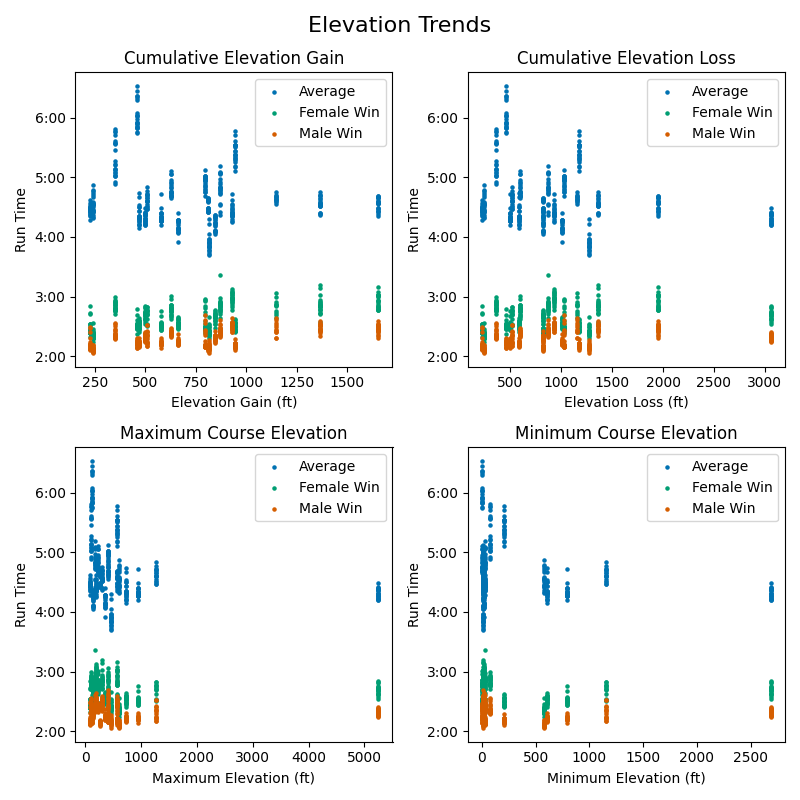

In [15]:
# Plot elevation data
# 'Elev Gain', 'Elev Loss',
# 'Elev Max', 'Elev Min', 
fig, axs = plt.subplots(2,2,figsize=(8,8))
((ax1,ax2),(ax3,ax4)) = axs

ax1.scatter(full_df['Elev Gain'],y_average, s=5, label='Average')
ax1.scatter(full_df['Elev Gain'],y_female, s=5, label='Female Win')
ax1.scatter(full_df['Elev Gain'],y_male, s=5, label='Male Win')
ax1.set_xlabel('Elevation Gain (ft)')
ax1.set_ylabel('Run Time')
ax1.set_title('Cumulative Elevation Gain')

ax2.scatter(full_df['Elev Loss'],y_average, s=5, label='Average')
ax2.scatter(full_df['Elev Loss'],y_female, s=5, label='Female Win')
ax2.scatter(full_df['Elev Loss'],y_male, s=5, label='Male Win')
ax2.set_xlabel('Elevation Loss (ft)')
ax2.set_ylabel('Run Time')
ax2.set_title('Cumulative Elevation Loss')

ax3.scatter(full_df['Elev Max'],y_average, s=5, label='Average')
ax3.scatter(full_df['Elev Max'],y_female, s=5, label='Female Win')
ax3.scatter(full_df['Elev Max'],y_male, s=5, label='Male Win')
ax3.set_xlabel('Maximum Elevation (ft)')
ax3.set_ylabel('Run Time')
ax3.set_title('Maximum Course Elevation')

ax4.scatter(full_df['Elev Min'],y_average, s=5, label='Average')
ax4.scatter(full_df['Elev Min'],y_female, s=5, label='Female Win')
ax4.scatter(full_df['Elev Min'],y_male, s=5, label='Male Win')
ax4.set_xlabel('Minimum Elevation (ft)')
ax4.set_ylabel('Run Time')
ax4.set_title('Minimum Course Elevation')

# Set tick labels and legends
for ax in [ax1,ax2,ax3,ax4]:
    ax.yaxis.set_major_locator(mticker.MultipleLocator(base=3600))
    ax.yaxis.set_major_formatter(formatter)
    ax.legend()

fig.suptitle('Elevation Trends', fontsize=16)

fig.tight_layout()

## Objective 1: Modeling Average Marathon Times

The average marathon times were modeled with different types of regressors: linear, ridge, lasso, gradient boosting decision tree, and random forest. Model training and testing used a random 75%/25% split of the data set. Since regularized linear models are sensitive to large differences in scale for input variables, a normal scaler transformation based on training split mean and st. dev. was applied to each input variable for ridge and lasso models using a pipeline. (Tree-based models did not need this type of feature scaling.) Grid searches with 5-fold cross validation were used on the training split to select the best hyperparameters for each model. The modeling performance results are summarized below in Table 1 within the section Summary of Objective 1 Findings.

### Modeling Setup

In [16]:
# Load full data
directory = 'full_df_csvs'
newest_full_df = [file for file in sorted(os.listdir(directory)) if file.endswith('.csv')][-1]
full_df = pd.read_csv(os.path.join(directory, newest_full_df))

# Update data types
full_df['Date'] = pd.to_datetime(full_df['Date'])
time_cols = ['Male Win','Female Win','Average Time','Time STD']
full_df[time_cols] = (full_df[time_cols].apply(pd.to_timedelta))

# full_df.dtypes

#### Create Train-Test Split

In [17]:
# Train-test split is random
from sklearn.model_selection import train_test_split

# Feature Variables (Excludes these cols from the df: 'Event Name', 'City', 'State')
X = full_df[[
            'Date', 'Finishers', 'Males', 'Females', 'Percent Female', 
            'Elev Gain', 'Elev Loss', 'Elev Max', 'Elev Min', 
            'STATION', 'LATITUDE', 'LONGITUDE', 'ELEVATION', 
            'TEMP', 'MAX', 'MIN', 'PRCP', 'DEWP', 'WDSP', 'RELHUM'
            ]]
# Dates will be in days (float) since Jan 1, 2000
X['Date'] = (pd.to_datetime(X['Date']) - pd.to_datetime('2000-01-01'))/np.timedelta64(1, 'D')

# Target Variables: Run times will be in seconds (float)
y_average = full_df['Average Time'] / np.timedelta64(1, 's')
y_male = full_df['Male Win'] / np.timedelta64(1, 's')
y_female = full_df['Female Win'] / np.timedelta64(1, 's')

X_ave_train, X_ave_test, y_ave_train, y_ave_test = train_test_split(X, y_average, random_state=0)
X_f_train, X_f_test, y_f_train, y_f_test = train_test_split(X, y_female, random_state=0)
X_m_train, X_m_test, y_m_train, y_m_test = train_test_split(X, y_male, random_state=0)

# X.dtypes
# y_average.dtypes

In [18]:
print(f'Total events: {len(X)}')
print(f'Train events: {len(X_ave_train)}')
print(f'Test events: {len(X_ave_test)}')
print(f'Split Fraction: {len(X_ave_test)/len(X)}')

Total events: 406
Train events: 304
Test events: 102
Split Fraction: 0.2512315270935961


In [19]:
# Create summary df to store scores and model coefficients
summary_df = pd.DataFrame(columns=['Params','Train R2','Test R2','CV R2 mean','CV R2 stdev',
                                   'Train RMSE','Test RMSE','Intercept']+list(X_ave_train.columns))

### Linear Regression with Cross Validation

In [20]:
# Linear Regression with K-fold cross-validation
from sklearn.linear_model import LinearRegression, Ridge, Lasso

# Create a CV instance that shuffles
shuffle_cv = KFold(n_splits=5, shuffle=True, random_state=0)

# Linear Regression on train split with 5-fold cross validation
linreg_ave_cv = cross_val_score(LinearRegression(), X_ave_train, y_ave_train, cv=shuffle_cv)

# Linear Regression on whole train split
linreg_ave = LinearRegression().fit(X_ave_train, y_ave_train)

# Populate results in summary df
summary_df.loc['Linear Ave','Train R2'] = linreg_ave.score(X_ave_train, y_ave_train)
summary_df.loc['Linear Ave','Test R2'] = linreg_ave.score(X_ave_test, y_ave_test)
summary_df.loc['Linear Ave','CV R2 mean'] = np.mean(linreg_ave_cv)
summary_df.loc['Linear Ave','CV R2 stdev'] = np.std(linreg_ave_cv)
summary_df.loc['Linear Ave','Intercept'] = linreg_ave.intercept_
summary_df.loc['Linear Ave'].iloc[8:28] = linreg_ave.coef_

# Calculate residuals and RMSE in minutes
linear_train_resid = (y_ave_train - linreg_ave.predict(X_ave_train))/60
linear_test_resid = (y_ave_test - linreg_ave.predict(X_ave_test))/60
summary_df.loc['Linear Ave','Train RMSE'] = ((linear_train_resid**2).mean())**0.5
summary_df.loc['Linear Ave','Test RMSE'] = ((linear_test_resid**2).mean())**0.5

### Ridge and Lasso Regression with Grid Search Cross-validation

In [21]:
# Ridge Regression: Grid Search with K-fold cross-validation

# Define a Standard Scaler to normalize inputs
scaler = StandardScaler()

# Create instances for regressor, CV, pipline, and hyperparameter grid values
ridge_ave = Ridge(random_state=0)
shuffle_cv = KFold(n_splits=5, shuffle=True, random_state=0)
pipe = Pipeline(steps=[('scaler', scaler), ('ridge_ave', ridge_ave)])
grid_values = {'ridge_ave__alpha': [0.01, 0.1, 1, 10]}

# Perform grid search cv on the train split
grid_ridge_ave = GridSearchCV(pipe, param_grid = grid_values, cv=shuffle_cv)
grid_ridge_ave.fit(X_ave_train, y_ave_train)
grid_ridge_ave_df = pd.DataFrame(grid_ridge_ave.cv_results_)

# Populate results in summary df
summary_df.loc['Ridge Ave','Params'] = [grid_ridge_ave.best_params_]
summary_df.loc['Ridge Ave','Train R2'] = grid_ridge_ave.best_estimator_.score(X_ave_train, y_ave_train)
summary_df.loc['Ridge Ave','Test R2'] = grid_ridge_ave.best_estimator_.score(X_ave_test, y_ave_test)
summary_df.loc['Ridge Ave','CV R2 mean'] = grid_ridge_ave.best_score_
summary_df.loc['Ridge Ave','CV R2 stdev'] = grid_ridge_ave_df.loc[grid_ridge_ave.best_index_,'std_test_score']
summary_df.loc['Ridge Ave','Intercept'] = grid_ridge_ave.best_estimator_.named_steps['ridge_ave'].intercept_
summary_df.loc['Ridge Ave'].iloc[8:28] = grid_ridge_ave.best_estimator_.named_steps['ridge_ave'].coef_

# Calculate residuals and RMSE in minutes
ridge_train_resid = (y_ave_train - grid_ridge_ave.predict(X_ave_train))/60
ridge_test_resid = (y_ave_test - grid_ridge_ave.predict(X_ave_test))/60
summary_df.loc['Ridge Ave','Train RMSE'] = ((ridge_train_resid**2).mean())**0.5
summary_df.loc['Ridge Ave','Test RMSE'] = ((ridge_test_resid**2).mean())**0.5

print(f'Best Ridge Model Paramters for Average Run Times:\n {grid_ridge_ave.best_params_}\n')

Best Ridge Model Paramters for Average Run Times:
 {'ridge_ave__alpha': 0.1}



In [22]:
# View Grid Search data table if desired by uncommenting
# pd.DataFrame(grid_ridge_ave.cv_results_)

In [23]:
# Lasso Regression: Grid Search with K-fold cross-validation

# Define a Standard Scaler to normalize inputs
scaler = StandardScaler()

# Create instances for regressor, CV, pipline, and hyperparameter grid values
lasso_ave = Lasso(max_iter=10000, random_state=0)
shuffle_cv = KFold(n_splits=5, shuffle=True, random_state=0)
pipe = Pipeline(steps=[('scaler', scaler), ('lasso_ave', lasso_ave)])
grid_values = {'lasso_ave__alpha': [0.01, 0.1, 1, 10]}

# Perform grid search cv on the train split
grid_lasso_ave = GridSearchCV(pipe, param_grid = grid_values, cv=shuffle_cv)
grid_lasso_ave.fit(X_ave_train, y_ave_train)
grid_lasso_ave_df = pd.DataFrame(grid_lasso_ave.cv_results_)

# Populate results in summary df
summary_df.loc['Lasso Ave','Params'] = [grid_lasso_ave.best_params_]
summary_df.loc['Lasso Ave','Train R2'] = grid_lasso_ave.best_estimator_.score(X_ave_train, y_ave_train)
summary_df.loc['Lasso Ave','Test R2'] = grid_lasso_ave.best_estimator_.score(X_ave_test, y_ave_test)
summary_df.loc['Lasso Ave','CV R2 mean'] = grid_lasso_ave.best_score_
summary_df.loc['Lasso Ave','CV R2 stdev'] = grid_lasso_ave_df.loc[grid_lasso_ave.best_index_,'std_test_score']
summary_df.loc['Lasso Ave','Intercept'] = grid_lasso_ave.best_estimator_.named_steps['lasso_ave'].intercept_
summary_df.loc['Lasso Ave'].iloc[8:28] = grid_lasso_ave.best_estimator_.named_steps['lasso_ave'].coef_

# Calculate residuals and RMSE in minutes
lasso_train_resid = (y_ave_train - grid_lasso_ave.predict(X_ave_train))/60
lasso_test_resid = (y_ave_test - grid_lasso_ave.predict(X_ave_test))/60
summary_df.loc['Lasso Ave','Train RMSE'] = ((lasso_train_resid**2).mean())**0.5
summary_df.loc['Lasso Ave','Test RMSE'] = ((lasso_test_resid**2).mean())**0.5

print(f'Best Lasso Model Paramters for Average Run Times:\n {grid_lasso_ave.best_params_}\n')

/Users/michael/Documents/PythonCoding/environments/datasci5/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.697e+07, tolerance: 7.778e+04
  model = cd_fast.enet_coordinate_descent(
/Users/michael/Documents/PythonCoding/environments/datasci5/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.026e+07, tolerance: 7.835e+04
  model = cd_fast.enet_coordinate_descent(
/Users/michael/Documents/PythonCoding/environments/datasci5/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to inc

Best Lasso Model Paramters for Average Run Times:
 {'lasso_ave__alpha': 1}



In [24]:
# View Grid Search data table if desired by uncommenting
# pd.DataFrame(grid_lasso_ave.cv_results_)

### Gradient Boosting and Random Forest Tree Ensembles with Grid Search Cross-validation

In [25]:
# Gradient Boosting Tree Ensembles: Grid Search with K-fold cross-validation

# Create KFold CV instance and hyperparameter grid values
shuffle_cv = KFold(n_splits=5, shuffle=True, random_state=0)
grid_values = {'max_depth': [1, 2, 3, 4],
               'learning_rate': [0.01, 0.02, 0.05, 0.1, 0.2],
               'n_estimators': [50, 100, 150, 200, 250]}

# Perform grid search cv on the train split
gb_ave = GradientBoostingRegressor(random_state=0)
grid_gb_ave = GridSearchCV(gb_ave, param_grid = grid_values, cv=shuffle_cv)
grid_gb_ave.fit(X_ave_train, y_ave_train)
grid_gb_ave_df = pd.DataFrame(grid_gb_ave.cv_results_)

# Populate results in summary df
summary_df.loc['Gradient Boosting Ave','Params'] = [grid_gb_ave.best_params_]
summary_df.loc['Gradient Boosting Ave','Train R2'] = grid_gb_ave.best_estimator_.score(X_ave_train, y_ave_train)
summary_df.loc['Gradient Boosting Ave','Test R2'] = grid_gb_ave.best_estimator_.score(X_ave_test, y_ave_test)
summary_df.loc['Gradient Boosting Ave','CV R2 mean'] = grid_gb_ave.best_score_
summary_df.loc['Gradient Boosting Ave','CV R2 stdev'] = grid_gb_ave_df.loc[grid_gb_ave.best_index_,'std_test_score']

# Calculate residuals and RMSE in minutes
gb_train_resid = (y_ave_train - grid_gb_ave.predict(X_ave_train))/60
gb_test_resid = (y_ave_test - grid_gb_ave.predict(X_ave_test))/60
summary_df.loc['Gradient Boosting Ave','Train RMSE'] = ((gb_train_resid**2).mean())**0.5
summary_df.loc['Gradient Boosting Ave','Test RMSE'] = ((gb_test_resid**2).mean())**0.5

print(f'Best Gradient Boosting Model Paramters for Average Run Times:\n {grid_gb_ave.best_params_}\n')

Best Gradient Boosting Model Paramters for Average Run Times:
 {'learning_rate': 0.2, 'max_depth': 1, 'n_estimators': 250}



In [26]:
# View best grid search data series if desired by uncommenting
# pd.DataFrame(grid_gb_ave.cv_results_).loc[grid_gb_ave.best_index_]

In [27]:
# Random Forest Tree Ensembles: Grid Search with K-fold cross-validation

# Create KFold CV instance and hyperparameter grid values
shuffle_cv = KFold(n_splits=5, shuffle=True, random_state=0)
grid_values = {'max_features': [0.2, 0.3, 0.4, 0.6, 0.8, 1.0],
               'max_samples': [0.6, 0.8, 1.0]}

# Perform grid search cv on the train split
rf_ave = RandomForestRegressor(n_estimators=250, random_state=0)
grid_rf_ave = GridSearchCV(rf_ave, param_grid = grid_values, cv=shuffle_cv)
grid_rf_ave.fit(X_ave_train, y_ave_train)
grid_rf_ave_df = pd.DataFrame(grid_rf_ave.cv_results_)

# Populate results in summary df
summary_df.loc['Random Forest Ave','Params'] = [grid_rf_ave.best_params_]
summary_df.loc['Random Forest Ave','Train R2'] = grid_rf_ave.best_estimator_.score(X_ave_train, y_ave_train)
summary_df.loc['Random Forest Ave','Test R2'] = grid_rf_ave.best_estimator_.score(X_ave_test, y_ave_test)
summary_df.loc['Random Forest Ave','CV R2 mean'] = grid_rf_ave.best_score_
summary_df.loc['Random Forest Ave','CV R2 stdev'] = grid_rf_ave_df.loc[grid_rf_ave.best_index_,'std_test_score']

# Calculate residuals and RMSE in minutes
rf_train_resid = (y_ave_train - grid_rf_ave.predict(X_ave_train))/60
rf_test_resid = (y_ave_test - grid_rf_ave.predict(X_ave_test))/60
summary_df.loc['Random Forest Ave','Train RMSE'] = ((rf_train_resid**2).mean())**0.5
summary_df.loc['Random Forest Ave','Test RMSE'] = ((rf_test_resid**2).mean())**0.5

print(f'Best Random Forest Model Paramters for Average Run Times:\n {grid_rf_ave.best_params_}\n')

Best Random Forest Model Paramters for Average Run Times:
 {'max_features': 0.6, 'max_samples': 1.0}



In [28]:
# View best grid search data series if desired by uncommenting
# pd.DataFrame(grid_rf_ave.cv_results_).loc[grid_rf_ave.best_index_]

In [29]:
# View model performance summary
summary_df

,Params,Train R2,Test R2,CV R2 mean,CV R2 stdev,Train RMSE,Test RMSE,Intercept,Date,Finishers,...,LATITUDE,LONGITUDE,ELEVATION,TEMP,MAX,MIN,PRCP,DEWP,WDSP,RELHUM
Linear Ave,NaN,0.772337,0.761092,0.696343,0.048797,14.051733,16.020429,14244.423505,0.023173,-9.657455,...,-119.404034,-28.575458,1.817525,64.29928,-15.429983,-28.514067,253.48204,21.233308,-55.072811,-0.014805
Ridge Ave,[{'ridge_ave__alpha': 0.1}],0.770101,0.760004,0.720239,0.037854,14.120561,16.056862,16726.815789,58.714563,107.55109,...,-796.903941,-625.178728,378.507836,515.324202,-158.246054,-219.51438,51.963693,311.615544,-200.311948,-60.447346
Lasso Ave,[{'lasso_ave__alpha': 1}],0.769822,0.760795,0.723282,0.037984,14.129128,16.030393,16726.815789,56.634684,0.0,...,-790.254073,-612.966093,359.108383,493.222781,-124.350731,-185.204306,49.366601,263.445572,-201.192323,-32.066183
Gradient Boosting Ave,"[{'learning_rate': 0.2, 'max_depth': 1, 'n_est...",0.976153,0.93377,0.936253,0.018465,4.54782,8.43501,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Random Forest Ave,"[{'max_features': 0.6, 'max_samples': 1.0}]",0.993026,0.949048,0.941806,0.016268,2.459433,7.398395,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Plot Performance of Tree Ensembles for Ave Times

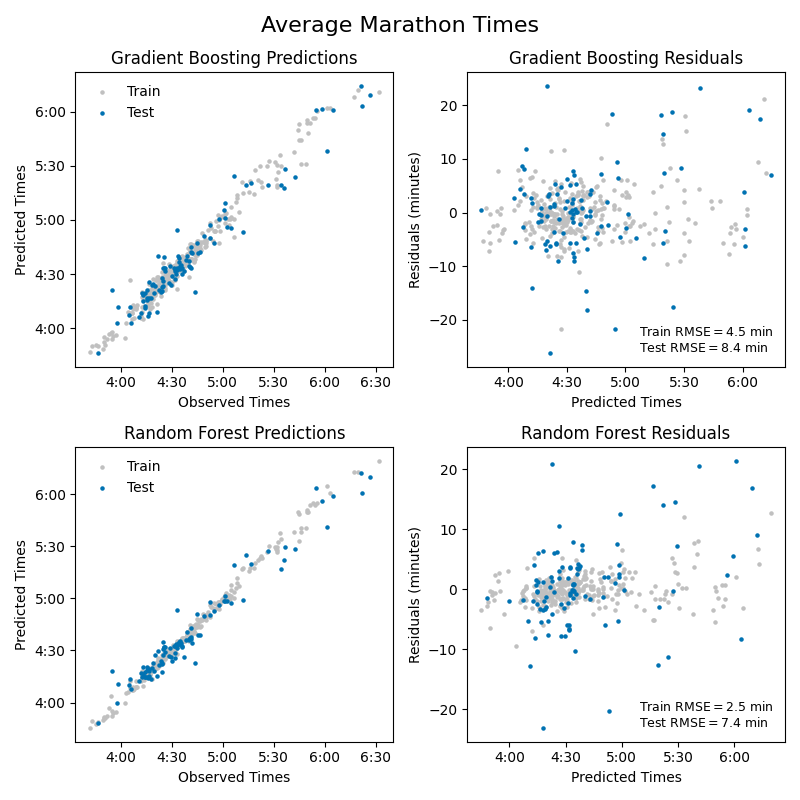

In [31]:
fig, axs = plt.subplots(2,2,figsize=(8,8))
((ax1,ax2),(ax3,ax4)) = axs

# Ave Gradient Boosting Model
y_ave_test_gb = grid_gb_ave.predict(X_ave_test)
y_ave_train_gb = grid_gb_ave.predict(X_ave_train)

ax1.scatter(y_ave_train,y_ave_train_gb, s=5, label='Train', color='silver')
ax1.scatter(y_ave_test,y_ave_test_gb, s=5, label='Test')
ax1.set_xlabel('Observed Times')
ax1.set_ylabel('Predicted Times')
ax1.set_title('Gradient Boosting Predictions')

# Ave Gradient Boosting Residuals
ax2.scatter(y_ave_train_gb, gb_train_resid, s=5, label='Train', color='silver')
ax2.scatter(y_ave_test_gb, gb_test_resid, s=5, label='Test')
ax2.set_xlabel('Predicted Times')
ax2.set_ylabel('Residuals (minutes)')
ax2.set_title('Gradient Boosting Residuals')

# Ave Random Forest Model
y_ave_test_rf = grid_rf_ave.predict(X_ave_test)
y_ave_train_rf = grid_rf_ave.predict(X_ave_train)

ax3.scatter(y_ave_train,y_ave_train_rf, s=5, label='Train', color='silver')
ax3.scatter(y_ave_test,y_ave_test_rf, s=5, label='Test')
ax3.set_xlabel('Observed Times')
ax3.set_ylabel('Predicted Times')
ax3.set_title('Random Forest Predictions')

# Ave Random Forest Residuals
ax4.scatter(y_ave_train_rf, rf_train_resid, s=5, label='Train', color='silver')
ax4.scatter(y_ave_test_rf, rf_test_resid, s=5, label='Test')
ax4.set_xlabel('Predicted Times')
ax4.set_ylabel('Residuals (minutes)')
ax4.set_title('Random Forest Residuals')

# Create annotations for fit metrics
gb_note = AnchoredText(f"Train RMSE$={summary_df.loc['Gradient Boosting Ave','Train RMSE']:.1f}$ min\nTest RMSE$={summary_df.loc['Gradient Boosting Ave','Test RMSE']:.1f}$ min",
                     prop=dict(size=9), frameon=False, loc='lower right')
rf_note = AnchoredText(f"Train RMSE$={summary_df.loc['Random Forest Ave','Train RMSE']:.1f}$ min\nTest RMSE$={summary_df.loc['Random Forest Ave','Test RMSE']:.1f}$ min",
                     prop=dict(size=9), frameon=False, loc='lower right')
ax2.add_artist(gb_note)
ax4.add_artist(rf_note)

# Set tick labels and legends
for ax in [ax1,ax3]:
    ax.yaxis.set_major_locator(mticker.MultipleLocator(base=1800))
    ax.yaxis.set_major_formatter(formatter)
    ax.xaxis.set_major_locator(mticker.MultipleLocator(base=1800))
    ax.xaxis.set_major_formatter(formatter)
    ax.legend(loc='upper left', frameon=False)
for ax in [ax2,ax4]:
    ax.xaxis.set_major_locator(mticker.MultipleLocator(base=1800))
    ax.xaxis.set_major_formatter(formatter)
    # ax.legend(loc='upper left')

fig.suptitle('Average Marathon Times', fontsize=16)

fig.tight_layout()

### Summary of Objective 1 Findings

The modeling performance results are summarized below in Table 1. For average marathon times, the best model tested here was the random forest regressor with an R<sup>2</sup> of 0.94 for the test data split, indicating the vast majority of the variation in average marathon run times could be predicted based on the input variables, including weather, elevation, and location. R<sup>2</sup> values for 5-fold cross-validation showed a st. dev. <0.02, which suggests this high model performance holds steady on previously unseen data. The gradient boosting tree ensemble showed similarly strong performance, so these fits for these two tree ensembles are plotted below.

#### Table 1: Model Performance

|   Model | Best Params  |   Train R<sup>2</sup> |   Test R<sup>2</sup> |   CV R<sup>2</sup> mean |   CV R<sup>2</sup> stdev |   Train RMSE |   Test RMSE |   Train Split stdev |   Test Split stdev |
|----------:|:-----------|:-----------:|:----------:|:--------:|:-----------:|:----------:|:------------:|:-------------:|:------------:|
| Ridge Ave                | [{'alpha': 0.1}]                                              |   0.770101 |  0.760004 |     0.720597 |     0.0383809 |     14.1206  |    16.0569  |            29.4499  |           32.7762  |
| Lasso Ave                | [{'alpha': 1}]                                                |   0.769705 |  0.760624 |     0.723293 |     0.0386154 |     14.1327  |    16.0361  |            29.4499  |           32.7762  |
| Linear Ave               | N/A                                                           |   0.772337 |  0.761092 |     0.696343 |     0.0487966 |     14.0517  |    16.0204  |            29.4499  |           32.7762  |
| Gradient Boosting Ave    | [{'learning_rate': 0.2, 'max_depth': 1, 'n_estimators': 250}] |   0.976153 |  0.93377  |     0.936253 |     0.018465  |      4.54782 |     8.43501 |            29.4499  |           32.7762  |
| Random Forest Ave        | [{'max_features': 0.6, 'max_samples': 1.0}]                   |   0.993026 |  __0.949048__ |     0.941806 |     0.016268  |      2.45943 |     7.3984  |            29.4499  |           32.7762  |
| Ridge Female Win         | [{'alpha': 0.01}]                                             |   0.48608  |  0.545343 |     0.432089 |     0.074542  |      8.77589 |     8.43108 |            12.2417  |           12.5038  |
| Random Forest Female Win | [{'max_features': 0.3, 'max_samples': 1.0}]                   |   0.972522 |  __0.822653__ |     0.795746 |     0.0351898 |      2.02924 |     5.26566 |            12.2417  |           12.5038  |
| Ridge Male Win           | [{'alpha': 0.01}]                                             |   0.508736 |  0.605073 |     0.440895 |     0.0518985 |      5.74884 |     5.20146 |             8.20205 |            8.27689 |
| Random Forest Male Win   | [{'max_features': 0.2, 'max_samples': 1.0}]                   |   0.974109 |  __0.86465__  |     0.790649 |     0.0434219 |      1.31976 |     3.04506 |             8.20205 |            8.27689 |


#### Tree Ensemble Plots: Ave Times
![Image](figures/Ave_Tree_Models.png)

Linear models (including ridge regression and lasso regression) each had a test split R<sup>2</sup> of 0.76, so these methods were less capable of predicting the variation in average run times. Linear models likely show lower performance for this data set because some of the important input variables are not expected to have linear effects on race times. For example, each race location (described by latitude and longitude) tends to attract a different population of marathon runners due to factors like race reputation or proximity to home. Tree-based methods are better able to learn and account for these effects, which are more categorical in nature.

## Objective 2: Modeling Marathon Win Times

Female and male win times were modeled with random forests and ridge regressors. Random forests were tested because this model type had the best performance of all regressors tested for average times. Ridge regressor was also included because linear models are easy to interpret based on variable coefficients (we will make use of this for objective 3). Hyperparameters for each model were tuned using grid search with 5-fold cross-validation of the training split, like with the ave time models. As before, the ridge model also used a normal scaler pipeline.

### Ridge Regression for Female and Male Win Times

In [49]:
# Female Win Times - Ridge Regression: Grid Search with K-fold cross-validation

# Define a Standard Scaler to normalize inputs
scaler = StandardScaler()

# Create instances for regressor, CV, pipline, and hyperparameter grid values
ridge_female = Ridge(random_state=0)
shuffle_cv = KFold(n_splits=5, shuffle=True, random_state=0)
pipe = Pipeline(steps=[('scaler', scaler), ('ridge_female', ridge_female)])
grid_values = {'ridge_female__alpha': [0.01, 0.1, 1, 10]}

# Perform grid search cv on the train split
grid_ridge_female = GridSearchCV(pipe, param_grid = grid_values, cv=shuffle_cv)
grid_ridge_female.fit(X_f_train, y_f_train)
grid_ridge_female_df = pd.DataFrame(grid_ridge_female.cv_results_)

# Populate results in summary df
summary_df.loc['Ridge Female Win','Params'] = [grid_ridge_female.best_params_]
summary_df.loc['Ridge Female Win','Train R2'] = grid_ridge_female.best_estimator_.score(X_f_train, y_f_train)
summary_df.loc['Ridge Female Win','Test R2'] = grid_ridge_female.best_estimator_.score(X_f_test, y_f_test)
summary_df.loc['Ridge Female Win','CV R2 mean'] = grid_ridge_female.best_score_
summary_df.loc['Ridge Female Win','CV R2 stdev'] = grid_ridge_female_df.loc[grid_ridge_female.best_index_,'std_test_score']
summary_df.loc['Ridge Female Win','Intercept'] = grid_ridge_female.best_estimator_.named_steps['ridge_female'].intercept_
summary_df.loc['Ridge Female Win'].iloc[8:28] = grid_ridge_female.best_estimator_.named_steps['ridge_female'].coef_

# Calculate residuals and RMSE in minutes
ridge_train_resid = (y_f_train - grid_ridge_female.predict(X_f_train))/60
ridge_test_resid = (y_f_test - grid_ridge_female.predict(X_f_test))/60
summary_df.loc['Ridge Female Win','Train RMSE'] = ((ridge_train_resid**2).mean())**0.5
summary_df.loc['Ridge Female Win','Test RMSE'] = ((ridge_test_resid**2).mean())**0.5

print(f'Best Ridge Model Paramters for Female Win Times:\n {grid_ridge_female.best_params_}\n')

Best Ridge Model Paramters for Female Win Times:
 {'ridge_female__alpha': 0.01}



In [34]:
# View Grid Search data table if desired by uncommenting
# pd.DataFrame(grid_ridge_female.cv_results_)

In [50]:
# Male Win Times - Ridge Regression: Grid Search with K-fold cross-validation

# Define a Standard Scaler to normalize inputs
scaler = StandardScaler()

# Create instances for regressor, CV, pipline, and hyperparameter grid values
ridge_male = Ridge(random_state=0)
shuffle_cv = KFold(n_splits=5, shuffle=True, random_state=0)
pipe = Pipeline(steps=[('scaler', scaler), ('ridge_male', ridge_male)])
grid_values = {'ridge_male__alpha': [0.01, 0.1, 1, 10]}

# Perform grid search cv on the train split
grid_ridge_male = GridSearchCV(pipe, param_grid = grid_values, cv=shuffle_cv)
grid_ridge_male.fit(X_m_train, y_m_train)
grid_ridge_male_df = pd.DataFrame(grid_ridge_male.cv_results_)

# Populate results in summary df
summary_df.loc['Ridge Male Win','Params'] = [grid_ridge_male.best_params_]
summary_df.loc['Ridge Male Win','Train R2'] = grid_ridge_male.best_estimator_.score(X_m_train, y_m_train)
summary_df.loc['Ridge Male Win','Test R2'] = grid_ridge_male.best_estimator_.score(X_m_test, y_m_test)
summary_df.loc['Ridge Male Win','CV R2 mean'] = grid_ridge_male.best_score_
summary_df.loc['Ridge Male Win','CV R2 stdev'] = grid_ridge_male_df.loc[grid_ridge_male.best_index_,'std_test_score']
summary_df.loc['Ridge Male Win','Intercept'] = grid_ridge_male.best_estimator_.named_steps['ridge_male'].intercept_
summary_df.loc['Ridge Male Win'].iloc[8:28] = grid_ridge_male.best_estimator_.named_steps['ridge_male'].coef_

# Calculate residuals and RMSE in minutes
ridge_train_resid = (y_m_train - grid_ridge_male.predict(X_m_train))/60
ridge_test_resid = (y_m_test - grid_ridge_male.predict(X_m_test))/60
summary_df.loc['Ridge Male Win','Train RMSE'] = ((ridge_train_resid**2).mean())**0.5
summary_df.loc['Ridge Male Win','Test RMSE'] = ((ridge_test_resid**2).mean())**0.5

print(f'Best Ridge Model Paramters for Male Win Times:\n {grid_ridge_male.best_params_}\n')

Best Ridge Model Paramters for Male Win Times:
 {'ridge_male__alpha': 0.01}



In [36]:
# View Grid Search data table if desired by uncommenting
# pd.DataFrame(grid_ridge_male.cv_results_)

In [37]:
# View model performance summary
summary_df

,Params,Train R2,Test R2,CV R2 mean,CV R2 stdev,Train RMSE,Test RMSE,Intercept,Date,Finishers,...,LATITUDE,LONGITUDE,ELEVATION,TEMP,MAX,MIN,PRCP,DEWP,WDSP,RELHUM
Linear Ave,NaN,0.772337,0.761092,0.696343,0.048797,14.051733,16.020429,14244.423505,0.023173,-9.657455,...,-119.404034,-28.575458,1.817525,64.29928,-15.429983,-28.514067,253.48204,21.233308,-55.072811,-0.014805
Ridge Ave,[{'ridge_ave__alpha': 0.1}],0.770101,0.760004,0.720239,0.037854,14.120561,16.056862,16726.815789,58.714563,107.55109,...,-796.903941,-625.178728,378.507836,515.324202,-158.246054,-219.51438,51.963693,311.615544,-200.311948,-60.447346
Lasso Ave,[{'lasso_ave__alpha': 1}],0.769822,0.760795,0.723282,0.037984,14.129128,16.030393,16726.815789,56.634684,0.0,...,-790.254073,-612.966093,359.108383,493.222781,-124.350731,-185.204306,49.366601,263.445572,-201.192323,-32.066183
Gradient Boosting Ave,"[{'learning_rate': 0.2, 'max_depth': 1, 'n_est...",0.976153,0.93377,0.936253,0.018465,4.54782,8.43501,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Random Forest Ave,"[{'max_features': 0.6, 'max_samples': 1.0}]",0.993026,0.949048,0.941806,0.016268,2.459433,7.398395,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Ridge Female Win,[{'ridge_female__alpha': 0.01}],0.48608,0.545343,0.432018,0.074613,8.775885,8.431078,9487.868421,-35.955894,-743.639127,...,-14.374999,23.797391,-35.229379,258.734338,152.720534,-129.032833,-5.213685,-351.16348,-22.835381,288.482831
Ridge Male Win,[{'ridge_male__alpha': 0.01}],0.508736,0.605073,0.440888,0.051929,5.748835,5.201463,8259.483553,-5.446044,-648.312212,...,-11.030176,-18.485834,-23.28744,294.860428,41.975013,-102.994274,15.386349,-282.493909,-1.429135,231.167667


### Random Forest Tree Ensembles for Female and Male Win Times

In [38]:
# Female Win Times - Random Forest Tree Ensembles: Grid Search with K-fold cross-validation

# Create KFold CV instance and hyperparameter grid values
shuffle_cv = KFold(n_splits=5, shuffle=True, random_state=0)
grid_values = {'max_features': [0.2, 0.3, 0.4, 0.6, 0.8, 1.0],
               'max_samples': [0.6, 0.8, 1.0]}

# Perform grid search cv on the train split
rf_female = RandomForestRegressor(n_estimators=250, random_state=0)
grid_rf_female = GridSearchCV(rf_female, param_grid = grid_values, cv=shuffle_cv)
grid_rf_female.fit(X_f_train, y_f_train)
grid_rf_female_df = pd.DataFrame(grid_rf_female.cv_results_)

# Populate results in summary df
summary_df.loc['Random Forest Female Win','Params'] = [grid_rf_female.best_params_]
summary_df.loc['Random Forest Female Win','Train R2'] = grid_rf_female.best_estimator_.score(X_f_train, y_f_train)
summary_df.loc['Random Forest Female Win','Test R2'] = grid_rf_female.best_estimator_.score(X_f_test, y_f_test)
summary_df.loc['Random Forest Female Win','CV R2 mean'] = grid_rf_female.best_score_
summary_df.loc['Random Forest Female Win','CV R2 stdev'] = grid_rf_female_df.loc[grid_rf_female.best_index_,'std_test_score']

# Calculate residuals and RMSE in minutes
rf_train_resid_female = (y_f_train - grid_rf_female.predict(X_f_train))/60
rf_test_resid_female = (y_f_test - grid_rf_female.predict(X_f_test))/60
summary_df.loc['Random Forest Female Win','Train RMSE'] = ((rf_train_resid_female**2).mean())**0.5
summary_df.loc['Random Forest Female Win','Test RMSE'] = ((rf_test_resid_female**2).mean())**0.5

print(f'Best Random Forest Model Paramters for Female Win Times:\n {grid_rf_female.best_params_}\n')

Best Random Forest Model Paramters for Female Win Times:
 {'max_features': 0.3, 'max_samples': 1.0}



In [39]:
# View best grid search data series if desired by uncommenting
# pd.DataFrame(grid_rf_female.cv_results_).loc[grid_rf_female.best_index_]

In [40]:
# Male Win Times - Random Forest Tree Ensembles: Grid Search with K-fold cross-validation

# Create KFold CV instance and hyperparameter grid values
shuffle_cv = KFold(n_splits=5, shuffle=True, random_state=0)
grid_values = {'max_features': [0.2, 0.3, 0.4, 0.6, 0.8, 1.0],
               'max_samples': [0.6, 0.8, 1.0]}

# Perform grid search cv on the train split
rf_male = RandomForestRegressor(n_estimators=250, random_state=0)
grid_rf_male = GridSearchCV(rf_male, param_grid = grid_values, cv=shuffle_cv)
grid_rf_male.fit(X_m_train, y_m_train)
grid_rf_male_df = pd.DataFrame(grid_rf_male.cv_results_)

# Populate results in summary df
summary_df.loc['Random Forest Male Win','Params'] = [grid_rf_male.best_params_]
summary_df.loc['Random Forest Male Win','Train R2'] = grid_rf_male.best_estimator_.score(X_m_train, y_m_train)
summary_df.loc['Random Forest Male Win','Test R2'] = grid_rf_male.best_estimator_.score(X_m_test, y_m_test)
summary_df.loc['Random Forest Male Win','CV R2 mean'] = grid_rf_male.best_score_
summary_df.loc['Random Forest Male Win','CV R2 stdev'] = grid_rf_male_df.loc[grid_rf_male.best_index_,'std_test_score']

# Calculate residuals and RMSE in minutes
rf_train_resid_male = (y_m_train - grid_rf_male.predict(X_m_train))/60
rf_test_resid_male = (y_m_test - grid_rf_male.predict(X_m_test))/60
summary_df.loc['Random Forest Male Win','Train RMSE'] = ((rf_train_resid_male**2).mean())**0.5
summary_df.loc['Random Forest Male Win','Test RMSE'] = ((rf_test_resid_male**2).mean())**0.5

print(f'Best Random Forest Model Paramters for Male Win Times:\n {grid_rf_male.best_params_}\n')

Best Random Forest Model Paramters for Male Win Times:
 {'max_features': 0.2, 'max_samples': 1.0}



In [41]:
# View best grid search data series if desired by uncommenting
# pd.DataFrame(grid_rf_male.cv_results_).loc[grid_rf_male.best_index_]

In [42]:
# Add st dev for target variables to summary table
def get_stdevs(index):
    if 'Ave' in index: return [np.std(y_ave_train)/60,np.std(y_ave_test)/60]
    elif 'Female' in index: return [np.std(y_f_train)/60,np.std(y_f_test)/60]
    elif 'Male' in index: return [np.std(y_m_train)/60,np.std(y_m_test)/60]
    else: return [np.nan,np.nan]

summary_df[['Train Split stdev','Test Split stdev']] = summary_df.apply(lambda x: get_stdevs(x.name), axis=1, result_type='expand')

# View Summary
(summary_df[['Train R2', 'Test R2', 'CV R2 mean', 'CV R2 stdev',
       'Train RMSE', 'Test RMSE', 'Train Split stdev', 'Test Split stdev']]
 .sort_values(['Train Split stdev','Test R2'],ascending=[False,True]))

,Train R2,Test R2,CV R2 mean,CV R2 stdev,Train RMSE,Test RMSE,Train Split stdev,Test Split stdev
Ridge Ave,0.770101,0.760004,0.720239,0.037854,14.120561,16.056862,29.449899,32.776219
Lasso Ave,0.769822,0.760795,0.723282,0.037984,14.129128,16.030393,29.449899,32.776219
Linear Ave,0.772337,0.761092,0.696343,0.048797,14.051733,16.020429,29.449899,32.776219
Gradient Boosting Ave,0.976153,0.93377,0.936253,0.018465,4.54782,8.43501,29.449899,32.776219
Random Forest Ave,0.993026,0.949048,0.941806,0.016268,2.459433,7.398395,29.449899,32.776219
Ridge Female Win,0.48608,0.545343,0.432018,0.074613,8.775885,8.431078,12.241746,12.503775
Random Forest Female Win,0.972522,0.822653,0.795746,0.03519,2.029242,5.265657,12.241746,12.503775
Ridge Male Win,0.508736,0.605073,0.440888,0.051929,5.748835,5.201463,8.202051,8.276886
Random Forest Male Win,0.974109,0.86465,0.790649,0.043422,1.319764,3.04506,8.202051,8.276886


### Plot Performance of Tree Ensembles for Female and Male Win Times

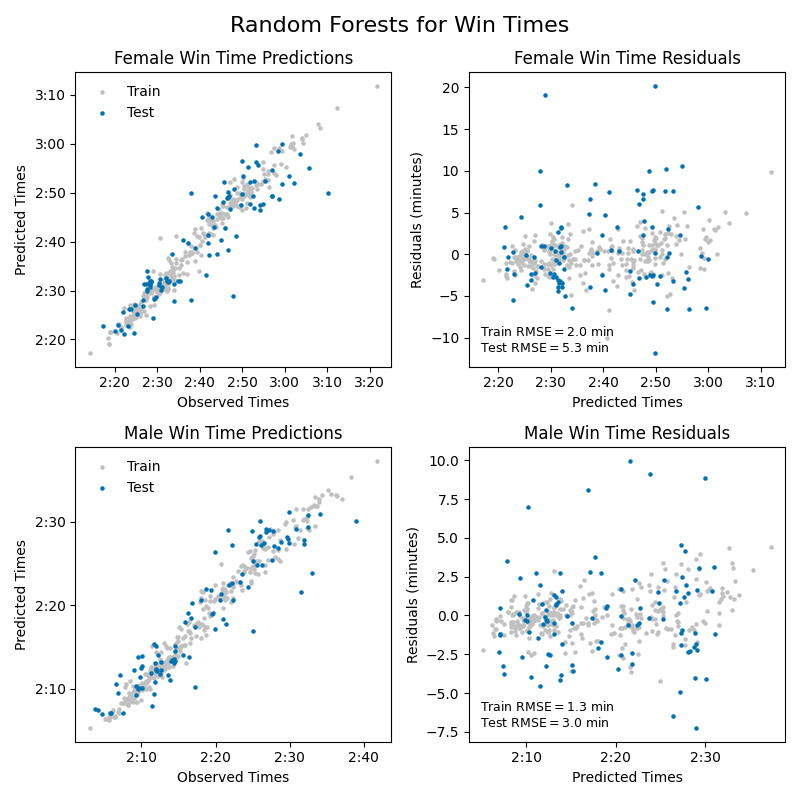

In [43]:
fig, axs = plt.subplots(2,2,figsize=(8,8))
((ax1,ax2),(ax3,ax4)) = axs

# Female Random Forest Model
y_f_train_rf = grid_rf_female.predict(X_f_train)
y_f_test_rf = grid_rf_female.predict(X_f_test)

ax1.scatter(y_f_train,y_f_train_rf, s=5, label='Train', color='silver')
ax1.scatter(y_f_test,y_f_test_rf, s=5, label='Test')
ax1.set_xlabel('Observed Times')
ax1.set_ylabel('Predicted Times')
ax1.set_title('Female Win Time Predictions')

# Female Random Forest Residuals
ax2.scatter(y_f_train_rf, rf_train_resid_female, s=5, label='Train', color='silver')
ax2.scatter(y_f_test_rf, rf_test_resid_female, s=5, label='Test')
ax2.set_xlabel('Predicted Times')
ax2.set_ylabel('Residuals (minutes)')
ax2.set_title('Female Win Time Residuals')

# Male Random Forest Model
y_m_train_rf = grid_rf_male.predict(X_m_train)
y_m_test_rf = grid_rf_male.predict(X_m_test)

ax3.scatter(y_m_train,y_m_train_rf, s=5, label='Train', color='silver')
ax3.scatter(y_m_test,y_m_test_rf, s=5, label='Test')
ax3.set_xlabel('Observed Times')
ax3.set_ylabel('Predicted Times')
ax3.set_title('Male Win Time Predictions')

# Male Random Forest Residuals
ax4.scatter(y_m_train_rf, rf_train_resid_male, s=5, label='Train', color='silver')
ax4.scatter(y_m_test_rf, rf_test_resid_male, s=5, label='Test')
ax4.set_xlabel('Predicted Times')
ax4.set_ylabel('Residuals (minutes)')
ax4.set_title('Male Win Time Residuals')

# Create annotations for fit metrics
female_note = AnchoredText(f"Train RMSE$={summary_df.loc['Random Forest Female Win','Train RMSE']:.1f}$ min\nTest RMSE$={summary_df.loc['Random Forest Female Win','Test RMSE']:.1f}$ min",
                     prop=dict(size=9), frameon=False, loc='lower left')
male_note = AnchoredText(f"Train RMSE$={summary_df.loc['Random Forest Male Win','Train RMSE']:.1f}$ min\nTest RMSE$={summary_df.loc['Random Forest Male Win','Test RMSE']:.1f}$ min",
                     prop=dict(size=9), frameon=False, loc='lower left')
ax2.add_artist(female_note)
ax4.add_artist(male_note)

# Set tick labels and legends
for ax in [ax1,ax3]:
    ax.yaxis.set_major_locator(mticker.MultipleLocator(base=600))
    ax.yaxis.set_major_formatter(formatter)
    ax.xaxis.set_major_locator(mticker.MultipleLocator(base=600))
    ax.xaxis.set_major_formatter(formatter)
    ax.legend(loc='upper left', frameon=False)
for ax in [ax2,ax4]:
    ax.xaxis.set_major_locator(mticker.MultipleLocator(base=600))
    ax.xaxis.set_major_formatter(formatter)
    # ax.legend(loc='upper left')

fig.suptitle('Random Forests for Win Times', fontsize=16)

fig.tight_layout()

### Plot All Random Forest Models Together

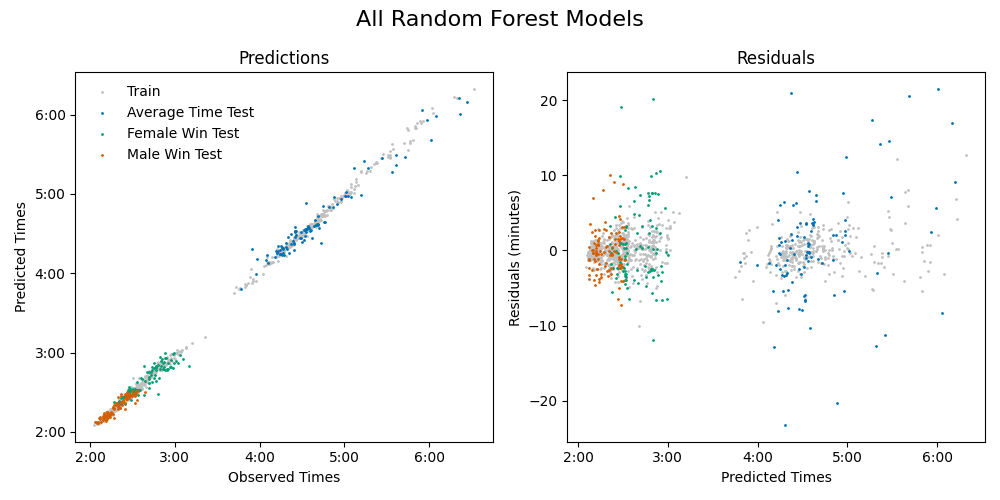

In [44]:
fig, axs = plt.subplots(1,2,figsize=(10,5))
(ax1,ax2) = axs

# Train Splits
ax1.scatter(y_ave_train,y_ave_train_rf, s=1, label='Train', color='silver')
ax1.scatter(y_f_train,y_f_train_rf, s=1, label='_Train', color='silver')
ax1.scatter(y_m_train,y_m_train_rf, s=1, label='_Train', color='silver')

# Test Splits
ax1.scatter(y_ave_test,y_ave_test_rf, s=1, label='Average Time Test')
ax1.scatter(y_f_test,y_f_test_rf, s=1, label='Female Win Test')
ax1.scatter(y_m_test,y_m_test_rf, s=1, label='Male Win Test')

ax1.set_xlabel('Observed Times')
ax1.set_ylabel('Predicted Times')
ax1.set_title('Predictions')

# Train Residuals
ax2.scatter(y_ave_train_rf, rf_train_resid, s=1, label='Train', color='silver')
ax2.scatter(y_f_train_rf, rf_train_resid_female, s=1, label='_Train', color='silver')
ax2.scatter(y_m_train_rf, rf_train_resid_male, s=1, label='_Train', color='silver')

# Test Residuals
ax2.scatter(y_ave_test_rf, rf_test_resid, s=1, label='Ave Test')
ax2.scatter(y_f_test_rf, rf_test_resid_female, s=1, label='Female Win Test')
ax2.scatter(y_m_test_rf, rf_test_resid_male, s=1, label='Male Win Test')

ax2.set_xlabel('Predicted Times')
ax2.set_ylabel('Residuals (minutes)')
ax2.set_title('Residuals')

# Set tick labels and legends
for ax in [ax1]:
    ax.yaxis.set_major_locator(mticker.MultipleLocator(base=3600))
    ax.yaxis.set_major_formatter(formatter)
    ax.xaxis.set_major_locator(mticker.MultipleLocator(base=3600))
    ax.xaxis.set_major_formatter(formatter)
    ax.legend(loc='upper left', frameon=False)
for ax in [ax2]:
    ax.xaxis.set_major_locator(mticker.MultipleLocator(base=3600))
    ax.xaxis.set_major_formatter(formatter)
    # ax.legend(loc='upper left')

fig.suptitle('All Random Forest Models', fontsize=16)

fig.tight_layout()

### Summary of Objective 2 Findings

As shown in Table 1 (reprinted below), random forest regressors were the better models for win times, with R<sup>2</sup> values of 0.82 for women and 0.86 for men. The random forest models ave times, female wins, and male wins are all plotted together below. (Individual plots for just female win times and just male win times are included in the appendix.) In comparison, the ridge regressors scored 0.54 for women and 0.60 for men. These scores for win time models are lower than the respective R<sup>2</sup> values for average times, and this is likely related to differences in observed time variances.

In general, female win times and male win times show less variance than average run times. One likely explanation is that typical marathon runners are strongly affected by adverse weather and hilly courses, creating a large amount of variance in observed average marathon times. In comparison,  elite runners are better able to adapt to conditions and perform consistently, leading to low variance in win times. As such, weather and course conditions were able to predict a smaller proportion of variance for win times than for average run times, as reflected in the R<sup>2</sup> scores. In order to explain a larger proportion of win time variance, other variables could be considered, such as scheduling conflicts with competing races (Olympic Games, Olympic Trials, prestigeous marathons) and prize money.

#### Table 1: Model Performance

|   Model | Best Params  |   Train R<sup>2</sup> |   Test R<sup>2</sup> |   CV R<sup>2</sup> mean |   CV R<sup>2</sup> stdev |   Train RMSE |   Test RMSE |   Train Split stdev |   Test Split stdev |
|----------:|:-----------|:-----------:|:----------:|:--------:|:-----------:|:----------:|:------------:|:-------------:|:------------:|
| Ridge Ave                | [{'alpha': 0.1}]                                              |   0.770101 |  0.760004 |     0.720597 |     0.0383809 |     14.1206  |    16.0569  |            29.4499  |           32.7762  |
| Lasso Ave                | [{'alpha': 1}]                                                |   0.769705 |  0.760624 |     0.723293 |     0.0386154 |     14.1327  |    16.0361  |            29.4499  |           32.7762  |
| Linear Ave               | N/A                                                           |   0.772337 |  0.761092 |     0.696343 |     0.0487966 |     14.0517  |    16.0204  |            29.4499  |           32.7762  |
| Gradient Boosting Ave    | [{'learning_rate': 0.2, 'max_depth': 1, 'n_estimators': 250}] |   0.976153 |  0.93377  |     0.936253 |     0.018465  |      4.54782 |     8.43501 |            29.4499  |           32.7762  |
| Random Forest Ave        | [{'max_features': 0.6, 'max_samples': 1.0}]                   |   0.993026 |  __0.949048__ |     0.941806 |     0.016268  |      2.45943 |     7.3984  |            29.4499  |           32.7762  |
| Ridge Female Win         | [{'alpha': 0.01}]                                             |   0.48608  |  0.545343 |     0.432089 |     0.074542  |      8.77589 |     8.43108 |            12.2417  |           12.5038  |
| Random Forest Female Win | [{'max_features': 0.3, 'max_samples': 1.0}]                   |   0.972522 |  __0.822653__ |     0.795746 |     0.0351898 |      2.02924 |     5.26566 |            12.2417  |           12.5038  |
| Ridge Male Win           | [{'alpha': 0.01}]                                             |   0.508736 |  0.605073 |     0.440895 |     0.0518985 |      5.74884 |     5.20146 |             8.20205 |            8.27689 |
| Random Forest Male Win   | [{'max_features': 0.2, 'max_samples': 1.0}]                   |   0.974109 |  __0.86465__  |     0.790649 |     0.0434219 |      1.31976 |     3.04506 |             8.20205 |            8.27689 |

#### Random Forest Plots: Win Times
![Image](figures/Random_Forests_plots.png)

In [45]:
# View Summary
(summary_df[['Params','Train R2', 'Test R2', 'CV R2 mean', 'CV R2 stdev',
       'Train RMSE', 'Test RMSE', 'Train Split stdev', 'Test Split stdev']]
 .sort_values(['Train Split stdev','Test R2'],ascending=[False,True]))

,Params,Train R2,Test R2,CV R2 mean,CV R2 stdev,Train RMSE,Test RMSE,Train Split stdev,Test Split stdev
Ridge Ave,[{'ridge_ave__alpha': 0.1}],0.770101,0.760004,0.720239,0.037854,14.120561,16.056862,29.449899,32.776219
Lasso Ave,[{'lasso_ave__alpha': 1}],0.769822,0.760795,0.723282,0.037984,14.129128,16.030393,29.449899,32.776219
Linear Ave,NaN,0.772337,0.761092,0.696343,0.048797,14.051733,16.020429,29.449899,32.776219
Gradient Boosting Ave,"[{'learning_rate': 0.2, 'max_depth': 1, 'n_est...",0.976153,0.93377,0.936253,0.018465,4.54782,8.43501,29.449899,32.776219
Random Forest Ave,"[{'max_features': 0.6, 'max_samples': 1.0}]",0.993026,0.949048,0.941806,0.016268,2.459433,7.398395,29.449899,32.776219
Ridge Female Win,[{'ridge_female__alpha': 0.01}],0.48608,0.545343,0.432018,0.074613,8.775885,8.431078,12.241746,12.503775
Random Forest Female Win,"[{'max_features': 0.3, 'max_samples': 1.0}]",0.972522,0.822653,0.795746,0.03519,2.029242,5.265657,12.241746,12.503775
Ridge Male Win,[{'ridge_male__alpha': 0.01}],0.508736,0.605073,0.440888,0.051929,5.748835,5.201463,8.202051,8.276886
Random Forest Male Win,"[{'max_features': 0.2, 'max_samples': 1.0}]",0.974109,0.86465,0.790649,0.043422,1.319764,3.04506,8.202051,8.276886


## Objective 3: Quantifying Effects of Race Conditions

Many marathon runners have faced challenging race conditions, including hot temperatures and hilly courses. Pacing goals should be adjusted based on these factors to ensure runner start their races at a sustainable speed and are less likely to resign to walking the last several miles. The modeling of this data set can offer some rough guidance in adjusting marathon pacing plans.

### Effect of each variable on race times

In [46]:
# Create df to highlight which race factors are most beneficial and detrimental
coef_df = (summary_df.loc[['Ridge Ave','Ridge Female Win','Ridge Male Win']].T.iloc[8:]
           .sort_values('Ridge Ave')
           .rename(columns={'Ridge Ave':'Ave Coef','Ridge Female Win':'Female Win Coef','Ridge Male Win':'Male Win Coef'})
          )

# Function to categorize race factors on how they affect average race time
def good_or_bad(coef):
    cutoff = 0
    if coef > cutoff: return 'Detrimental'
    elif coef < -cutoff: return 'Beneficial'
    else: return 'Low-Impact'

# Add column for Average Effect
coef_df['Ave Effect'] = coef_df['Ave Coef'].apply(good_or_bad)

# StandardScaler transformation performed using training std dev to convert to unscaled coefs.
stdev_df = X_m_train.std().to_frame()
stdev_df.columns = ['St Dev']
coef_df = coef_df.merge(stdev_df, how='inner', left_index=True, right_index=True)

# Convert 'ELEVATION' stdev from meters to feet
coef_df.loc['ELEVATION','St Dev'] = coef_df.loc['ELEVATION','St Dev']*3.281
# Convert 'WDSP' stdev from knots to mph
coef_df.loc['WDSP','St Dev'] = coef_df.loc['WDSP','St Dev']*1.15078

# To allow interpretation of coefficients, we will reverse the StandardScaler.
coef_df['Ave Unscaled Coef'] = coef_df.apply(lambda x: x['Ave Coef']/x['St Dev'], axis=1)
coef_df['Female Win Unscaled Coef'] = coef_df.apply(lambda x: x['Female Win Coef']/x['St Dev'], axis=1)
coef_df['Male Win Unscaled Coef'] = coef_df.apply(lambda x: x['Male Win Coef']/x['St Dev'], axis=1)

In [47]:
coef_df

,Ave Coef,Female Win Coef,Male Win Coef,Ave Effect,St Dev,Ave Unscaled Coef,Female Win Unscaled Coef,Male Win Unscaled Coef
Elev Min,-2237.629337,-1882.369285,-1449.636249,Beneficial,6.135957e+02,-3.646749e+00,-3.067768e+00,-2.362527e+00
Elev Loss,-2223.888481,-1500.503083,-1160.824414,Beneficial,6.169816e+02,-3.604465e+00,-2.432006e+00,-1.881457e+00
LATITUDE,-796.903941,-14.374999,-11.030176,Beneficial,6.786179e+00,-1.174304e+02,-2.118276e+00,-1.625388e+00
LONGITUDE,-625.178728,23.797391,-18.485834,Beneficial,2.245497e+01,-2.784144e+01,1.059783e+00,-8.232402e-01
MIN,-219.51438,-129.032833,-102.994274,Beneficial,1.037966e+01,-2.114852e+01,-1.243132e+01,-9.922707e+00
WDSP,-200.311948,-22.835381,-1.429135,Beneficial,4.087516e+00,-4.900579e+01,-5.586616e+00,-3.496342e-01
MAX,-158.246054,152.720534,41.975013,Beneficial,1.135177e+01,-1.394022e+01,1.345346e+01,3.697664e+00
Females,-106.798647,569.864418,476.169408,Beneficial,4.829041e+03,-2.211591e-02,1.180078e-01,9.860538e-02
RELHUM,-60.447346,288.482831,231.167667,Beneficial,1.731968e+01,-3.490096e+00,1.665636e+01,1.334711e+01
STATION,-45.342979,-38.384759,-41.519072,Beneficial,3.931089e+09,-1.153446e-08,-9.764408e-09,-1.056172e-08


### Summary of Objective 3 Findings

While linear models did not perform as well as tree-based methods for this data set, they are still able to account for the majority of run time variance and offer interpretable results via the model coefficients. Prior to fitting the linear models, input variables were each normalized using a standard scaler. After fitting, each coefficient was transformed back into original units based on the respective variable's st. dev. Unscaled coefficients for the ridge model are listed below for some variables that runners might want to account for. (A slightly faster than average runner would likely want to make adjustments somewhere between the values for ave times and win times.)

#### Table 2: Highlights on How to Adjust Goal Race Time:
(These are are in relation to what you consider your "normal" training conditions.)

| Variable | Units | Ave Effect | Female Win Effect | Male Win Effect |
|------:|:------:|:------:|:------:|:------:|
| Temperature | sec/deg F | +52 | +26 | +30 |
| Relative Humidity | sec/% | -3 | +17 | +13 |
| Precipitation | sec/inch | +263 | -26 | +78 |
| Wind | sec/mph | -49 | -6 | 0 |
| Elevation | sec/foot | +0.5 | 0.0 | 0.0 |
| Cumulative Elev Loss | sec/foot | -3.6 | -2.4 | -1.9 |
| Cumulative Elev Gain | sec/foot | +3.1 | +2.6 | +1.9 |

These numbers are only to give a rough idea on how to quantify the added difficulty of race conditions while controlling for other variables. Experienced runners know flat courses and easier/faster than hilly courses with zero net elevation change, but the coefficients for the model examined here suggest the hilly course would be about the same. Data from a larger variety of race course elevation profiles would help to improve these coefficient estimates. Likewise, some variables such as precipitation had sparse data with heavily skewed distributions, so coefficient estimates for these variables would improve with additional data. Runners likely will still find these quantified adjustments valuable for pacing if they choose to travel to unfamiliar territory for a marathon with a notably different climate and elevation profile than they are used to.

In [48]:
(coef_df.loc[['Date','TEMP','DEWP','RELHUM','PRCP','WDSP',
             'ELEVATION','Elev Gain','Elev Loss']]
        .sort_values('Ave Coef')
        [['Ave Effect','Ave Unscaled Coef','Female Win Unscaled Coef','Male Win Unscaled Coef']]
)

,Ave Effect,Ave Unscaled Coef,Female Win Unscaled Coef,Male Win Unscaled Coef
Elev Loss,Beneficial,-3.604465,-2.432006,-1.881457
WDSP,Beneficial,-49.005792,-5.586616,-0.349634
RELHUM,Beneficial,-3.490096,16.656361,13.347110
PRCP,Detrimental,263.315176,-26.419263,77.967116
Date,Detrimental,0.025540,-0.015641,-0.002369
DEWP,Detrimental,26.156744,-29.476365,-23.712299
ELEVATION,Detrimental,0.504527,-0.046959,-0.031041
TEMP,Detrimental,51.629236,25.922043,29.541439
Elev Gain,Detrimental,3.081212,2.581306,1.885723


# Scratch Work

In [60]:
# Code for copying a dataframe to the clipboard in markdown format
temp_df_output = (summary_df[['Params','Train R2', 'Test R2', 'CV R2 mean', 'CV R2 stdev',
       'Train RMSE', 'Test RMSE', 'Train Split stdev', 'Test Split stdev']]
 .sort_values(['Train Split stdev','Test R2'],ascending=[False,True]))
pd.io.clipboards.to_clipboard(temp_df_output.to_markdown(), excel=False)

In [ ]:
coef_df

In [ ]:
coef_df.loc[['Date','TEMP','DEWP','RELHUM','PRCP','WDSP',
             'ELEVATION','Elev Gain','Elev Loss'],
            ['Ave Effect','Ave Coef','Ave Unscaled Coef']
           ].sort_values('Ave Coef')